# Pairwise-cross correlation 

- PCC (pairwise cross-correlation) quantifies the temporal precision of a spike relative to events.
- PCCs were computed either at the motif or syllable level
- Run pcc.py to get the results 
- Read values from syllable_pcc or pcc

## Load data 

In [1]:
from analysis.parameters import fr_crit, nb_note_crit
from database.load import ProjectLoader
from deafening.plot import plot_bar_comparison, plot_per_day_block, plot_scatter_diagonal, plot_regression
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from util import save
from util.draw import remove_right_top
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Save path
save_path = save.make_dir(ProjectLoader().path / 'Analysis', 'Results', add_date=False)

# Load database
db = ProjectLoader().load_db()

## Plot PCC across days per syllable

- Undir songs only.

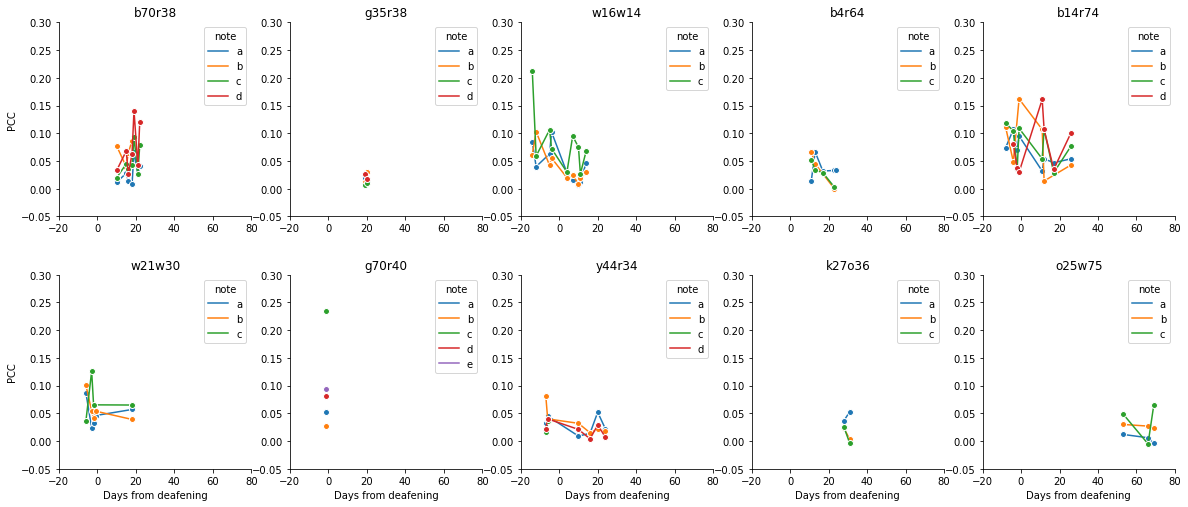

In [2]:
from deafening.plot import plot_across_days_per_note
query = f"""SELECT * FROM syllable_pcc WHERE frUndir >= {fr_crit} AND nbNoteUndir >={nb_note_crit}"""
df = db.to_dataframe(query)

plot_across_days_per_note(df, x='taskSessionDeafening', y='pccUndir',
                 x_label='Days from deafening',
                 y_label='PCC',
                 title=f'PCC Undir per day block FR >= {fr_crit} & # of Notes >= {nb_note_crit}',
                 fig_name='PCC_across_days',
                 x_lim=[-20, 80], y_lim=[-0.05, 0.3],
                 save_path=save_path,
                 save_fig=False,
                 )

## Compare PCC pre vs. post-deafening

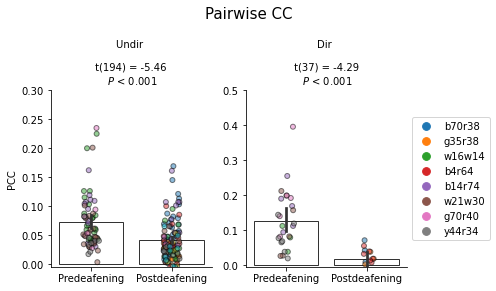

In [3]:
# Parameters
nb_row = 3
nb_col = 2

# Plot the results
fig, ax = plt.subplots(figsize=(7, 5))
plt.suptitle('Pairwise CC', y=.8, fontsize=15)

# Undir
query = f"SELECT * FROM syllable_pcc WHERE frUndir >= {fr_crit} AND " \
        f"nbNoteUndir >={nb_note_crit}"
df = db.to_dataframe(query)

df['pccUndir'].replace('', np.nan, inplace=True)  # replace empty values with nans to prevent an error
ax = plt.subplot2grid((nb_row, nb_col), (1, 0), rowspan=2, colspan=1)
plot_bar_comparison(ax, df['pccUndir'], df['taskName'], hue_var=df['birdID'],
                    title='Undir', y_label='PCC',
                    y_lim=[-0.005, 0.3],
                    col_order=("Predeafening", "Postdeafening"),
                    )

# Dir
query = f"SELECT * FROM syllable_pcc WHERE frDir >= {fr_crit} AND " \
        f"nbNoteUndir >={nb_note_crit}"
df = db.to_dataframe(query)

df['pccDir'].replace('', np.nan, inplace=True)  # replace empty values with nans to prevent an error
ax = plt.subplot2grid((nb_row, nb_col), (1, 1), rowspan=2, colspan=1)
plot_bar_comparison(ax, df['pccDir'], df['taskName'], hue_var=df['birdID'],
                    title='Dir', y_lim=[-0.005, 0.5],
                    col_order=("Predeafening", "Postdeafening"),
                    legend_ok=True
                    )
fig.tight_layout()
plt.show()

## Paired comparisons per bird


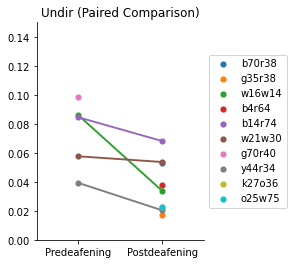

In [4]:
# Undir (paired comparisons)
# Undir
query = f"SELECT * FROM syllable_pcc WHERE frUndir >= {fr_crit} AND " \
        f"nbNoteUndir >={nb_note_crit}"
df = db.to_dataframe(query)

fig, ax = plt.subplots(figsize=(3, 4))

pcc_mean_per_condition = df.groupby(['birdID','taskName'])['pccUndir'].mean().to_frame()
pcc_mean_per_condition.reset_index(inplace = True)

sns.pointplot(x='taskName', y='pccUndir', hue = 'birdID',
                   data=pcc_mean_per_condition,
                   order=["Predeafening", "Postdeafening"],
                   aspect=.5, hue_order = df['birdID'].unique().tolist(), scale = 0.7, ax=ax)

ax.spines['right'].set_visible(False),ax.spines['top'].set_visible(False)

title = 'Undir (Paired Comparison)'
ax.set_title(title)
ax.set_xlabel(''), ax.set_ylabel('')
ax.set_ylim(0, 0.15), ax.set_xlim(-0.5, 1.5)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

## Paired comparisons between undir and dir

- Difference between pre and post goes away after deafening

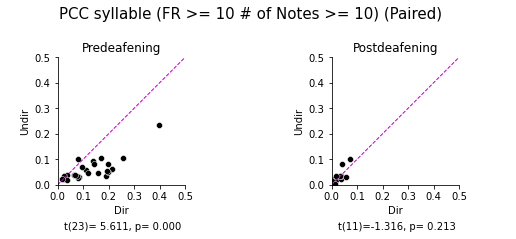

In [5]:
# Load database
query = f"SELECT * FROM syllable_pcc WHERE nbNoteUndir >= {nb_note_crit} AND " \
        f"nbNoteDir >= {nb_note_crit} AND " \
        f"frUndir >= {fr_crit} AND " \
        f"frDir >= {fr_crit}"

df = db.to_dataframe(query)

plot_scatter_diagonal(df, 'pccDir', 'pccUndir',
                      # hue='birdID',
                      save_folder_name='pcc',
                      x_lim=[0, 0.45],
                      y_lim=[0, 0.45],
                      x_label='Dir',
                      y_label='Undir', tick_freq=0.1,
                      title=f"PCC syllable (FR >= {fr_crit} # of Notes >= {nb_note_crit}) (Paired)",
                      save_fig=False,
                      view_folder=False,
                      fig_ext='.png')

## Plot the results across day blocks

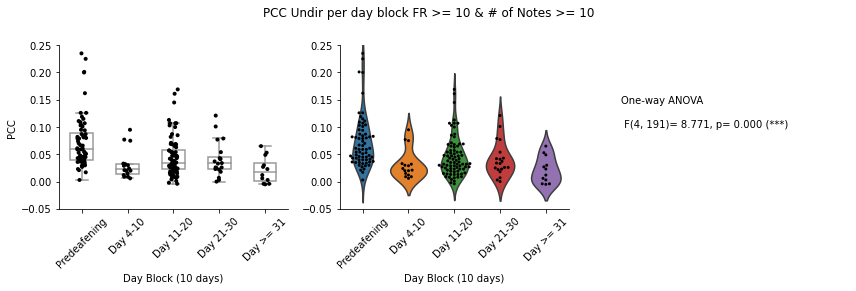

In [6]:
# Undir
query = f"SELECT * FROM syllable_pcc WHERE frUndir >= {fr_crit} AND " \
        f"nbNoteUndir >={nb_note_crit}"
df = db.to_dataframe(query)

# Plot pcc syllable across blocks
plot_per_day_block(df, ind_var_name='block10days', dep_var_name='pccUndir',
                   title=f'PCC Undir per day block FR >= {fr_crit} & # of Notes >= {nb_note_crit}',
                   y_label='PCC',
                   plot_type='box',
                   y_lim=[-0.05, 0.25],
                   view_folder=True,
                   fig_name='PCC_syllable_per_day_block',
                   save_fig=False, fig_ext='.png'
                   )


## Combine block 3 & 4

- Combine values from 3 and 4th block into a single block (Day >= 21)

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     0      1   -0.041 0.0012 -0.0691 -0.0129   True
     0      2  -0.0274  0.001 -0.0441 -0.0107   True
     0      3  -0.0393  0.001  -0.061 -0.0177   True
     1      2   0.0136 0.5731 -0.0141  0.0413  False
     1      3   0.0017    0.9 -0.0293  0.0326  False
     2      3  -0.0119 0.4644 -0.0331  0.0092  False
----------------------------------------------------


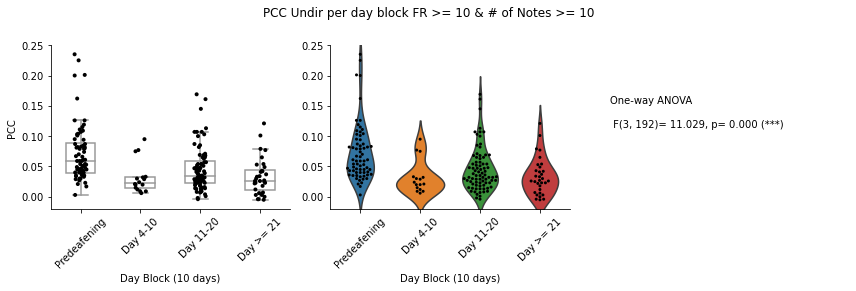

In [7]:
df['block10days'].replace(4, 3, inplace=True) 

# Plot pcc syllable across blocks
plot_per_day_block(df, ind_var_name='block10days', dep_var_name='pccUndir',
                   title=f'PCC Undir per day block FR >= {fr_crit} & # of Notes >= {nb_note_crit}',
                   y_label='PCC',
                   plot_type='box',
                   y_lim=[-0.02, 0.25],
                   view_folder=True, 
                   post_hoc=True,
                   fig_name='PCC_syllable_per_day_block',
                   save_fig=False, fig_ext='.png'
                   )

## Analyze pcc using different time windows (pre, syllable, post)

- read from syllable_pcc_window table

<img src="img/moving_window_pcc.png" width=900 height=900 />

- spike time window (gray) matching the duration of a syllable will shift relative to the onset to examine the dominance of the pre-motor component in LMAN spikes

- Select pccUndirPre, pccUndirSyllable, pccUndirPost, respectively.

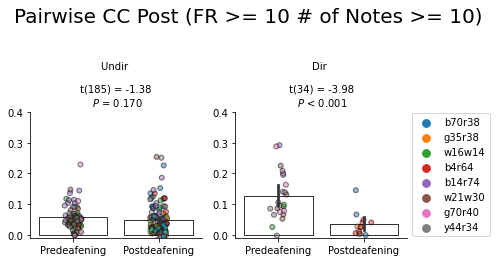

In [8]:
# Parameters
nb_row = 3
nb_col = 2
nb_note_crit = 10
fr_crit = 10

from deafening.plot import plot_bar_comparison

# Plot results
# Pairwise cross-correlation
fig, ax = plt.subplots(figsize=(7, 4))
plt.suptitle(f"Pairwise CC Post (FR >= {fr_crit} # of Notes >= {nb_note_crit})", y=.9, fontsize=20)

# Undir
# # SQL statement
query = f"SELECT * FROM syllable_pcc_window WHERE nbNoteUndir >= {nb_note_crit} AND frUndirPost >= {fr_crit}"
df_time_window = db.to_dataframe(query)

df_time_window['pccUndirPost'].replace('', np.nan, inplace=True)  # replace empty values with nans to prevent an error
ax = plt.subplot2grid((nb_row, nb_col), (1, 0), rowspan=2, colspan=1)
plot_bar_comparison(ax, df_time_window['pccUndirPost'], df_time_window['taskName'],
                    hue_var=df_time_window['birdID'],
                    title='Undir', ylabel='PCC',
                    #y_lim=[-0.01, round(df['pccUndirPre'].max() * 10) / 10 + 0.1],
                    y_lim=[-0.01, 0.4],
                    col_order=("Predeafening", "Postdeafening"),
                    )

# Dir
# # SQL statement
query = f"SELECT * FROM syllable_pcc_window WHERE nbNoteDir >= {nb_note_crit} AND frDirPost >= {fr_crit}"
df_time_window = db.to_dataframe(query)

df_time_window['pccDirPost'].replace('', np.nan, inplace=True)  # replace empty values with nans to prevent an error
ax = plt.subplot2grid((nb_row, nb_col), (1, 1), rowspan=2, colspan=1)
plot_bar_comparison(ax, df_time_window['pccDirPost'], df_time_window['taskName'],
                    hue_var=df_time_window['birdID'],
                    title='Dir',
                    #y_lim=[-0.01, round(df['pccDirPre'].max() * 10) / 10 + 0.2],
                    y_lim=[-0.01, 0.4],
                    col_order=("Predeafening", "Postdeafening"),
                    legend_ok=True
                    )
fig.tight_layout()
plt.show()

## Regression

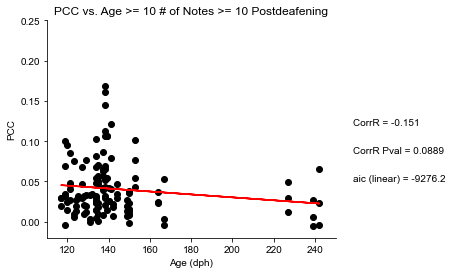

In [9]:
# PCC vs. DPH
# Pre
query = f"""SELECT * FROM syllable_pcc WHERE frUndir >= {fr_crit} 
AND nbNoteUndir >={nb_note_crit} 
AND taskName = 'Predeafening'"""
df = db.to_dataframe(query)

x=df['dph'].to_numpy()
y=df['pccUndir'].to_numpy()
title = f'PCC vs. Age >= {fr_crit} # of Notes >= {nb_note_crit} Predeafening'
x_label = 'Age (dph)'
y_label = 'PCC'
x_lim = [95, 130]
y_lim = [-0.02, 0.25]

plot_regression(x, y,
                title=title,
                x_label=x_label, y_label=y_label,
                x_lim=x_lim, y_lim=y_lim,
                fr_criteria=fr_crit,
                save_fig=True, fig_ext='.pdf',
                regression_type=['linear']
                )

# Post
query = f"""SELECT * FROM syllable_pcc WHERE frUndir >= {fr_crit} 
AND nbNoteUndir >={nb_note_crit} 
AND taskName = 'Postdeafening'"""
df = db.to_dataframe(query)

x=df['dph'].to_numpy()
y=df['pccUndir'].to_numpy()
title = f'PCC vs. Age >= {fr_crit} # of Notes >= {nb_note_crit} Postdeafening'
x_label = 'Age (dph)'
y_label = 'PCC'
x_lim = [110, 250]
y_lim = [-0.02, 0.25]

plot_regression(x, y,
                title=title,
                x_label=x_label, y_label=y_label,
                x_lim=x_lim, y_lim=y_lim,
                fr_criteria=fr_crit,
                save_fig=False, 
                regression_type=['linear']
                )


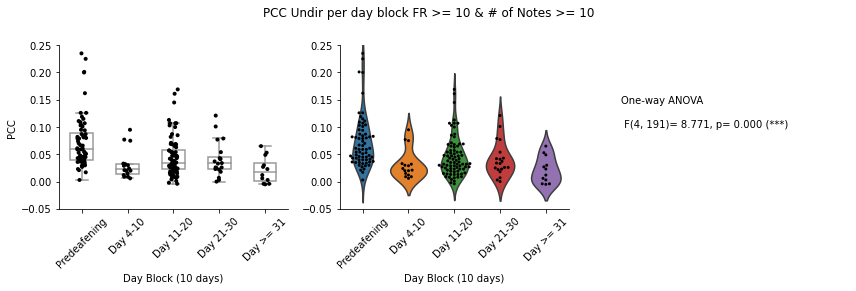

In [6]:
# Undir
query = f"SELECT * FROM syllable_pcc WHERE frUndir >= {fr_crit} AND " \
        f"nbNoteUndir >={nb_note_crit}"
df = db.to_dataframe(query)

# Plot pcc syllable across blocks
plot_per_day_block(df, ind_var_name='block10days', dep_var_name='pccUndir',
                   title=f'PCC Undir per day block FR >= {fr_crit} & # of Notes >= {nb_note_crit}',
                   y_label='PCC',
                   plot_type='box',
                   y_lim=[-0.05, 0.25],
                   view_folder=True,
                   fig_name='PCC_syllable_per_day_block',
                   save_fig=False, fig_ext='.png'
                   )


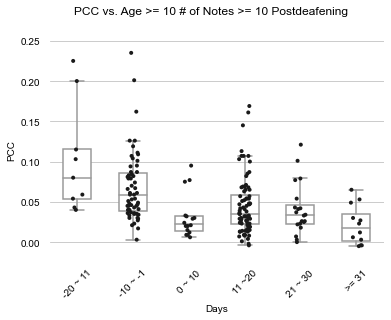

In [75]:
# Apply 10-day block for pre-deafening data

query = f"SELECT * FROM syllable_pcc WHERE frUndir >= {fr_crit} AND " \
        f"nbNoteUndir >={nb_note_crit}"
df = db.to_dataframe(query)

df['newBlock'] = pd.cut(df['taskSessionDeafening'], [-20, -10, 0, 10, 20, 30, 100], 
       labels=[-2, -1, 0, 1, 2, 3],    
       include_lowest=True
      )
# df[['newBlock', 'taskSessionDeafening', 'block10days']]

# Plot the results
x = df['newBlock']
y = df['pccUndir']
ind_groups = df['newBlock'].sort_values().unique()

fig, ax = plt.subplots(figsize=(6, 4))
plt.suptitle(title, y=1, fontsize=12)

sns.stripplot(x, y, ax=ax, color="k", jitter=0.1, size=4)
sns.boxplot(x, y, ax=ax, width=0.5, color='w', showfliers=False)

remove_right_top(ax)
ax.set(xlabel='Days', ylabel='PCC', ylim=(-0.02, 0.25))
day_block_label_list = ['-20 ~ 11', '-10 ~ -1', '0 ~ 10', '11 ~20', '21 ~ 30', '>= 31']  # left and right all inclusive
ax.set_xticklabels(day_block_label_list, rotation=45)
plt.show()